<a href="https://colab.research.google.com/github/Vacayy/nlp-study/blob/main/DistilBERT/DistilBERT_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DistilBERT fine-tuning으로 감정 분석 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 감정 분석 문제에 적용한다.


### Feature Extraction


> **전이 학습(Transfer Learning)의 아이디어:** '자연어 처리 문제들은 어차피 입력이 다 같은 자연어인데, 다른 자연어 처리 문제를 푸는 모델을 잘 활용하면 data가 적은 자연어 처리 문제도 풀 수 있는 것 아닐까?'


그 중에서 **Feature Extraction(특징 추출)**은 사전 학습된 모델에서 학습된 일반화된 표현(특징)을 추출하여, 이를 새로운 작업(task)에 활용하는 방법.
- 데이터가 많으면 파인튜닝(Fine-Tuning), 데이터가 적으면 특징 추출(Feature Extraction) 방식을 사용.


특징:
- 사전 학습된 모델의 일반화된 표현(특징)을 사용하여 추가적인 학습을 수행한다.
- 사전 학습된 모델의 가중치를 업데이트하지 않으므로 계산 비용이 낮다.
- 학습 데이터가 적을 때 유리.

In [ ]:
# 먼저 필요한 library들을 불러오기
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

그 후, 우리가 사용하는 DistilBERT를 pre-training 할 때 사용한 tokenizer를 불러온다.

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT의 토크나이저를 로드
# 'distilbert-base-uncased': 소문자로 변환된 영어 사전 기반 모델
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

DistilBERT의 tokenizer를 불러왔으므로, 이제 `collate_fn`과 data loader를 정의한다.

In [3]:
# IMDb 데이터셋 로드 ('stanfordnlp/imdb' 데이터셋)
ds = load_dataset("stanfordnlp/imdb")

# 데이터 배치의 전처리를 수행하는 함수 정의
def collate_fn(batch):
    max_len = 400  # 최대 토큰 길이 설정
    texts, labels = [], []

    for row in batch:
        labels.append(row['label'])  # 레이블 저장
        texts.append(row['text'])  # 텍스트 저장

    # 텍스트를 토크나이징하고 패딩 및 길이 제한 적용
    texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
    labels = torch.LongTensor(labels)  # 레이블을 텐서로 변환

    return texts, labels

# DataLoader 생성
train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

이제 pre-trained DistilBERT를 불러온다.

이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러보자.

In [4]:
# DistilBERT 모델 로드
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

출력 결과를 통해 우리는 DistilBERT의 architecture가 일반적인 Transformer와 동일한 것을 알 수 있다.


Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거친다.


이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현해보자.

In [ ]:
from torch import nn

# 텍스트 분류 모델 정의
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # DistilBERT를 인코더로 설정
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
        # 최종 출력 레이어 (768차원을 1차원으로 변환)
        self.classifier = nn.Linear(768, 1)

    def forward(self, x):
        # DistilBERT의 마지막 히든 상태 사용
        x = self.encoder(x)['last_hidden_state']
        # [CLS] 토큰에 해당하는 첫 번째 벡터만 사용하여 분류
        x = self.classifier(x[:, 0])
        return x

model = TextClassifier()

위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정한다.


그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환한다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현한다.

In [6]:
# DistilBERT의 가중치를 고정 (미세 조정하지 않음)
for param in model.encoder.parameters():
    param.requires_grad = False

# 파인튜닝의 경우, 이와 달리 사전 학습된 모델의 파라미터를 업데이트(requires_grad=True)하여 새로운 작업에 맞게 모델을 조정한다.

위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습이다.

`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않는다.

즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어진다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해보자.

In [7]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt


# 학습 설정
lr = 0.001  # 학습률
model = model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.BCEWithLogitsLoss()  # 바이너리 분류를 위한 손실 함수
optimizer = Adam(model.parameters(), lr=lr)  # Adam 옵티마이저
n_epochs = 10  # 학습 반복 횟수

train_losses = []  # 학습 손실 저장용 리스트

# 학습 루프
for epoch in range(n_epochs):
    total_loss = 0.
    model.train()

    for data in train_loader:
        model.zero_grad()  # 이전 그래디언트 초기화
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

        preds = model(inputs)[..., 0]  # 예측값 계산
        loss = loss_fn(preds, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        total_loss += loss.item()  # 손실 합산

    train_losses.append(total_loss)  # 에포크별 손실 기록
    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch   0 | Train Loss: 233.1759457886219
Epoch   1 | Train Loss: 198.9405408501625
Epoch   2 | Train Loss: 186.37972974777222
Epoch   3 | Train Loss: 178.22471910715103
Epoch   4 | Train Loss: 174.02926528453827
Epoch   5 | Train Loss: 171.57982927560806
Epoch   6 | Train Loss: 168.0426180958748
Epoch   7 | Train Loss: 167.7698239684105
Epoch   8 | Train Loss: 165.14067575335503
Epoch   9 | Train Loss: 165.4510255753994


In [8]:
# 정확도 계산 함수 정의
def accuracy(model, dataloader):
    cnt = 0  # 총 샘플 수
    acc = 0  # 정확히 예측한 샘플 수

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)  # 모델 예측
        preds = (preds > 0).long()[..., 0]  # 로짓값을 바이너리 클래스(0/1)로 변환

        cnt += labels.shape[0]  # 총 샘플 수 증가
        acc += (labels == preds).sum().item()  # 맞춘 샘플 수 증가

    return acc / cnt  # 정확도 반환

# 학습 및 테스트 정확도 측정
with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

=========> Train acc: 0.836 | Test acc: 0.827


Loss가 잘 떨어지고, 이전에 구현한 Transformer보다 더 빨리 수렴하는 것을 알 수 있다.

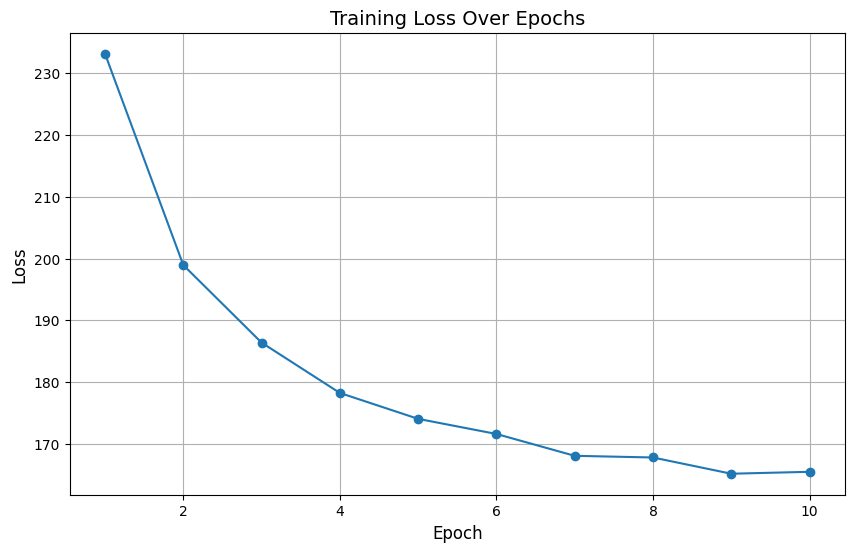

In [9]:
# 학습 손실 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.title('Training Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.show()